#### Version's detail (pour qu'on s'y retrouve)
V2 : Able to parse over wiki page info and turn into csv doc. Strugles with special character and disambiguation pages. Citations counts are weird

V2.1 : Solved the special character problem

V2.2 : Cleaned the table and formated the date. Added a little hist to view page creation along time

V2.3 : Adding a function to pass the 500 treshhold in scraping articles title

V2.4 : Adding the scraping of the titles of sub- and sub-sub-sections

In [2]:
!pip install wikipedia setuptools pywikibot mwparserfromhell pandas numpy scipy nltk tqdm seaborn pyqt5 pyqtwebengine ruamel-yaml lxml

In [4]:
import wikipedia
import re
import pywikibot
import requests
from bs4 import BeautifulSoup
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import seaborn as sns
import matplotlib.pyplot as plt
from urllib.request import urlopen
import json


In [5]:
wikipedia.set_lang("en")  #We make our research in english

#### definition of the function for the CORPUS SELECTION

In [1]:
def function_to_get_all_the_bloody_titles(key_words):
    titles = []
    a = key_words.lower().replace(' ', '+')
    scraped_url = 'https://en.wikipedia.org/w/index.php?title=Special:Search&limit=5000&offset=0&profile=default&search={}&ns0=1'.format(a)
    html_text = requests.get(scraped_url).text
    soup = BeautifulSoup(html_text, 'lxml')
    r = soup.find('div', {'class' : 'results-info'})
    nbr_result = int(r.get('data-mw-num-results-total'))
    for interest in soup.find_all('div', {'class' : 'mw-search-result-heading'}):
        titles.append(interest.find('a')['title'])
    return titles, nbr_result

In [2]:
def get_section_titles(page : str) -> list[str]:
    '''
    Returns the section titles

    :param page: Title of the page
    :return: The list of section titles
    '''
    section_tit = set()
    section_title = []
    scraped_url = wikipedia.page(page, auto_suggest = False).url
    html_text = requests.get(scraped_url).text
    soup = BeautifulSoup(html_text, 'lxml')
    r = soup.find_all('h2') + soup.find_all('h3') + soup.find_all('h4')
    for i in r:
        if i.find('span', {'class' : 'mw-headline'}) is not None:
            section_tit.add(i.find('span', {'class' : 'mw-headline'})['id'])
    for i in section_tit:
        section_title.append(i.replace('_', ' '))        
    return section_title

In [6]:
#We define a function to automatically set up a corpus of related articles
def corpus_selection(word_keys : str , number_of_results, key_for_section) -> list[str]:
    '''
    Select the corpus if the keywords are in the section or in the title

    :param word_keys : string 
    
    :return: a dictionnary containing the title of all the pages of the corpus
    '''
    corpus = []
    proper_list = []
    left_list = []
    function = function_to_get_all_the_bloody_titles(word_keys)
    nbr_result = function[1]
    search_list = function[0] #Select and put in a list number_of_results wikipedia articles related to word_keys
    
    for article in tqdm(search_list):
        try:
            wikipedia.summary(article, auto_suggest = False)
            proper_list.append(article)
        except wikipedia.exceptions.DisambiguationError as e:
            pass
        except wikipedia.exceptions.PageError as e:
            try:
                wikipedia.summary(article, auto_suggest = False)
                proper_list.append(article)
            except wikipedia.exceptions.PageError as e:
                pass
    
    for proper_article in tqdm(proper_list):
        if key_for_section in proper_article.lower(): #Among these articles, select the ones whose title contains key_for_selection for the corpus
            corpus.append(proper_article)
        else:
            left_list.append(proper_article) #Put the rest of the articles in a list
            
    for left_article in tqdm(left_list):
        sec_tit = []
        try :
            sec_tit = get_section_titles(left_article)
            for section in sec_tit:
                if key_for_section.lower() in section.lower() and left_article not in corpus:
                    corpus.append(left_article)
        except wikipedia.exceptions.DisambiguationError as e:
            pass
        except wikipedia.exceptions.PageError as e:
            try:
                sec_tit = get_section_titles(left_article)
                for section in sec_tit:
                    if key_for_section.lower() in section.lower() and left_article not in corpus:
                        corpus.append(left_article)
            except wikipedia.exceptions.PageError as e:
                pass

    return corpus[:number_of_results]

## TO LAUNCH THE CORPUS SELECTION

In [ ]:
%%time
search_list = corpus_selection("Effects of climate change", 5000, 'climate change')


  1%|▉                                                                               | 57/5000 [00:30<42:35,  1.93it/s]C:\Users\aaugr\anaconda3\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file C:\Users\aaugr\anaconda3\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')
  6%|████▊                                                                          | 303/5000 [02:42<41:45,  1.88it/s]

In [12]:
search_list=["Effects of climate change","Climate change", "Bird migration","Climate change in Alabama","Climate change in California","Climate change in Arizona"]


In [15]:
len(set(search_list))#gives us the number of article in our corpus

924

In [9]:
set(search_list)#gives us the title of our corpus

{'2008 United Nations Climate Change Conference',
 '2009 United Nations Climate Change Conference',
 '2010s oil glut',
 '2011 United Nations Climate Change Conference',
 '2012 United Nations Climate Change Conference',
 '2013 United Nations Climate Change Conference',
 '2014 United Nations Climate Change Conference',
 '2015 Commonwealth Heads of Government Meeting',
 '2015 United Nations Climate Change Conference',
 '2016 Louisiana floods',
 '2016 Pakistan Floods',
 '2016 United Nations Climate Change Conference',
 '2018 United Nations Climate Change Conference',
 '2019 in climate change',
 '2019 mass invasion of Russian polar bears',
 '2019–20 Australian bushfire season',
 '2020 California wildfires',
 '2020 Western United States wildfire season',
 '2020 in climate change',
 '2020s in environmental history',
 '2021 European floods',
 '2021 Maharashtra floods',
 '2021 United Nations Climate Change Conference',
 '2021 Western North America heat wave',
 '2021 in climate change',
 '2021–2

#### definition of the function for the extraction of citation

In [285]:
# Some additional functions
def get_ids_from_ref(ref):
    d = dict(re.findall(r'(doi|pmc|pmid)\s?[=\|]\s?([^|\s}]*)', ref))
    ids = {k: v for k, v in d.items() if v}
    return ids

        
def get_citations(wikicode):
    citations = [c.lower() for c in re.findall(r'<ref(?:\s(?:[^\/]*?))?>(.*?)<\/ref>', wikicode) + re.findall(r'({{(?:cite|vcite2|Cite)\s[^}]*}})', wikicode)]
    s = set()
    
    i=0
    for c in citations:
        i+=1
        #print("beginning of c",i,c,"end of c")
        s.update(c.split('<br/>'))
        
    ds = pd.DataFrame(s, columns=['ref'])
    
   
    ds['ids'] = ds['ref'].apply(get_ids_from_ref)
    ds['pmid'] = ds['ids'].apply(lambda x: x.get('pmid', None))
    ds['doi'] = ds['ids'].apply(lambda x: x.get('doi', None))
    ds['pmc'] = ds['ids'].apply(lambda x: x.get('pmc', None))
    ds["available"]=ds["ids"]== {}
    
    
    dsbis= ds[(~ds['pmid'].isnull())|~(ds['doi'].isnull())|~(ds['pmc'].isnull())]
    
    ds = ds[(~ds['pmid'].duplicated()) | (ds['pmid'].isnull())]
    ds = ds[(~ds['doi'].duplicated()) | (ds['doi'].isnull())]
    ds = ds[(~ds['pmc'].duplicated()) | (ds['pmc'].isnull())]


    dg=ds.loc[ds["available"]==True,["ref"]]
    dg['ids']=dg['ref'].apply(get_IPCC_guardian_ipbes_from_ref)
    dg['IPCC'] = dg['ids'].apply(lambda x: x.get('IPCC', None))
    dg['ipbes'] = dg['ids'].apply(lambda x: x.get('ipbes', None))
    dg['guard'] = dg['ids'].apply(lambda x: x.get('guardian', None))
    dg["available"]= dg["ids"]=={}
    
    
    
    dcit=dg.loc[dg["available"]==True,["ref"]]
    dcit['ids'] = dcit['ref'].apply(get_cit_from_ref)
    dcit['org'] = dcit['ids'].apply(lambda x: x.get('org', None))
    dcit['gov'] = dcit['ids'].apply(lambda x: x.get('gov', None))
    dcit['com'] = dcit['ids'].apply(lambda x: x.get('com', None))
    dcit["available"]= dcit["ids"]=={}
    
    #creation of a data frame with all the other type of citation that weren't extracted
    drest = dcit.loc[dcit["available"]==True,["ref"]]
    print(drest)
    
    dgbisgov=dcit[(~dcit['gov'].isnull())]
    
    dgbisorg=dcit[(~dcit['org'].isnull())]
    
    dgbisIPCC=dg[(~dg['IPCC'].isnull())]
    
    dgbiscom=dcit[(~dcit['com'].isnull())]
    
    
    return {'Ref count': ds.shape[0], 'nb_journal_citations': ds[(~ds['pmid'].isnull()) | (~ds['doi'].isnull()) | (~ds['pmc'].isnull())].shape[0],"citationjournal":list(list(dsbis["doi"])+list(dsbis["pmid"])+list(dsbis["pmc"])),"citations.org": dcit[(~dcit['org'].isnull())].shape[0],"citations.gov": dcit[(~dcit['gov'].isnull())].shape[0],"citationgovtext":list(dgbisgov['gov']),"citationorgtext":list(dgbisorg['org']),"citationsIPCC.ch": dg[(~dg['IPCC'].isnull())].shape[0],"citationautre":list(drest["ref"]),"citationcomtext":list(dgbiscom['com']),"citations.com": dcit[(~dcit['com'].isnull())].shape[0],"citationsipbes": dg[(~dg['ipbes'].isnull())].shape[0],"citationguardian": dg[(~dg['guard'].isnull())].shape[0]}

In [24]:
def get_cit_from_ref(ref):
    d = dict(re.findall(r"((?:[(?:\.)(?:\-)\w]*)\.(org|com|gov))", ref, flags=re.IGNORECASE))
    
    if 'web.archive.org' in d:
        d.pop('web.archive.org', None)
        #d.remove('web.archive.org') 
    ids = {v: k for k, v in d.items() if v}
    
    return ids

In [282]:
def get_IPCC_guardian_ipbes_from_ref(ref):
    g={}
    citation=list(set(re.findall(r"(ipcc|ipbes|guardian)", ref, flags=re.IGNORECASE)))
    if citation !=None and citation !=[]:
        if "ipcc" in citation:
            g["IPCC"]=citation
        if "ipbes" in citation:
            g["ipbes"]=citation
        if "guardian" in citation:
            g["guardian"]=citation
        return g
    else:
        return{}

#### creation du dataframe

In [280]:
%%time
def crea_dataframe(search_list : list,keyword : str)-> pd.DataFrame:
    '''
    param search_list: liste containing the name of all the articles
    param keyword: string containing the keyword that we want to scrap
    
    
    return: data frame containg the name, the url and the wikicode of the entire page if the keyword is in the title.
    If it's not it returns the wiki code of the section containing the keyword only.  
    '''
    tableau =[] #creation of a list that will contain a dictionnary for each page with the information
    recode= r'(?:==(?:\w|\ )*?(?:'+keyword[0].lower()+'|'+keyword[0].upper()+')'+keyword[1:]+'(?:\w|\ )*?==\n)((?:.|\n)*?)(?:==(?:\w|\ )*==\n)'
    recode2=r'(?:===(?:\w|\ )*?(?:'+keyword[0].lower()+'|'+keyword[0].upper()+')'+keyword[1:]+'(?:\w|\ )*?===\n)((?:.|\n)*?)(?:(?:===|==)(?:\w|\ )*(?:===|==)\n)'
    for i in range(len(search_list)):
             
        page =wikipedia.page(search_list[i], auto_suggest = False)
        page_title =page.title #give the clean name of the page
        page_url=page.url #give the url of the page
        site = pywikibot.Site("en", "wikipedia")
        page = pywikibot.Page(site, page_title)
        if keyword.lower() in page_title.lower(): 
            page_text=page.text
        else:
            page_text = str(re.findall(recode , page.text))
        if page_text=="[]":
            page_text = str(re.findall(recode2, page.text))
            
        infopage ={'Name only' : page_title, 'page url' :page_url,'text':page_text}
        tableau.append(infopage)
    df=pd.DataFrame.from_dict(tableau)
    return df


df=crea_dataframe(search_list,"climate change")
df

Wall time: 4.42 s


,Name only,page url,text
0,Effects of climate change,https://en.wikipedia.org/wiki/Effects_of_clima...,{{short description|Effects created by climate...
1,Climate change,https://en.wikipedia.org/wiki/Climate_change,{{Short description|Current rise in Earth's av...
2,Bird migration,https://en.wikipedia.org/wiki/Bird_migration,['Large scale [[global warming|climatic change...
3,Climate change in Alabama,https://en.wikipedia.org/wiki/Climate_change_i...,{{Short description|Climate change in the US s...
4,Climate change in California,https://en.wikipedia.org/wiki/Climate_change_i...,{{Short description|Climate change in the US s...
5,Climate change in Arizona,https://en.wikipedia.org/wiki/Climate_change_i...,{{Short description|Climate change in the US s...


#### extract from text document the wiki code

In [51]:
# %load '2008.txt'
def text_import(year : int):
    
    filename =str(year) +".txt"
    dataframe_name = pd.read_csv(filename, sep = '\t')
    print(type(dataframe_name))
    return str(dataframe_name)


In [9]:
 #creation of a list that will contain a dictionnary for each page with the information
for i in range(2006,2022):
    page =wikipedia.page(search_list[0], auto_suggest = False)
    page_title =i #give the clean name of the page
    page_url= "https://en.wikipedia.org/w/index.php?title=Effects_of_climate_change&oldid=298597212" #give the url of the page
    text=text_import(str(i))
    infopage ={'Name only' : page_title, 'page url' :page_url,'text':text}
    tableau.append(infopage)
    df=pd.DataFrame.from_dict(tableau)

NameError: name 'search_list' is not defined

In [118]:
df["text"]

0    []
Name: text, dtype: object

## Get the citations

In [286]:
print('Getting citations')
df['citations'] = df['text'].progress_apply(lambda x: get_citations(x))

print("getting the number of references")
df['Ref count'] = df['citations'].progress_apply(lambda x: x['Ref count'])

print("getting the number of scientific citations")
df['nb_journal_citations'] = df['citations'].progress_apply(lambda x: x['nb_journal_citations'])
df["journalcitation"] = df['citations'].progress_apply(lambda x: x['citationjournal'])

print("getting the number of .org citation")
df["citation org"]=df['citations'].progress_apply(lambda x: x['citations.org'])
df["citationorgtext"]=df['citations'].progress_apply(lambda x: x["citationorgtext"])

print("getting the number of .gov citation")
df["citation gov"]=df['citations'].progress_apply(lambda x: x["citations.gov"])
df["citationgovtext"]=df['citations'].progress_apply(lambda x: x["citationgovtext"])

print("getting the number of IPCC citation")
df["citation IPCC"]=df['citations'].progress_apply(lambda x: x["citationsIPCC.ch"])

print("getting the .com citations")
df["citation com"]=df['citations'].progress_apply(lambda x: x["citations.com"])
df["citationcomtext"]=df['citations'].progress_apply(lambda x: x["citationcomtext"])

print("getting the ipbes citation")
df["citationipbes"]=df['citations'].progress_apply(lambda x: x["citationsipbes"])

print("getting the guardian citation")
df["citationguardian"]=df['citations'].progress_apply(lambda x: x["citationguardian"])

print("getting the other citation")
df["citationautre"]=df['citations'].progress_apply(lambda x: x["citationautre"])

df["org count"]=df["citation org"]/df["Ref count"]
df["gov count"]=df["citation gov"]/df["Ref count"]
df["com count"]=df["citation com"]/df["Ref count"]
df["Sci count"]=df['nb_journal_citations']/df['Ref count']
df['IPCC count']=df['citation IPCC']/df['Ref count']
df['percentage of official sources']=(df['nb_journal_citations']+ df['citation gov']+ df['citation org']+df['citation IPCC']+df['citationipbes'])/df['Ref count']


print('Done!')
df.head()

Getting citations


 33%|████████████████████████████                                                        | 2/6 [00:00<00:00, 12.50it/s]

                                                   ref
26   environmental migrants: up to 1 billion by 205...
51   {{cite news |date=5 may 2020 |title=climate ch...
68         {{cite book|title=in {{harvnb|usgcrp|2017}}
78   [https://crowtherlab.pageflow.io/cities-of-the...
84   {{cite web |title=climate change: evidence and...
106  un-water (2013) [https://collections.unu.edu/e...
108  {{cite journal\n | last=tsosie | first=rebecca...
112      {{cite web|title=thermodynamics: albedo {{!}}
133  {{cite web\n | pages=3–4\n | last1=hansen | fi...
150  [https://serc.carleton.edu/eslabs/cryosphere/1...
176  {{cite web |title=who &#124; the global burden...
201  [https://www.climateforesight.eu/migrations/en...
213  {{cite web |title=motion for a resolution on t...
233  {{cite news |ref={{harvid|world resources inst...
255  {{cite book|last1=kennedy|first1=john|url=http...


 67%|████████████████████████████████████████████████████████                            | 4/6 [00:00<00:00, 14.17it/s]

                                                   ref
2    {{cite news |ref={{harvid|salon, 25 september|...
3                     {{harvnb|oxford languages|2019}}
5    {{harvnb|dessai|2001|p=4}}; {{harvnb|grubb|200...
9    {{cite book\n |last1=dunlap |first1=riley e.\n...
10        {{harvnb|ruseva|hedrick|marland|tovar|2020}}
..                                                 ...
595       {{harvnb|cohen|screen|furtado|barlow|2014}}.
596  {{harvnb|united nations environment programme|...
597                  {{harvnb|teske|2019|pp=409–410}}.
602         {{harvnb|doney|fabry|feely|kleypas|2009}}.
603  {{cite web |ref={{harvid|natural resources def...

[268 rows x 1 columns]
Empty DataFrame
Columns: [ref]
Index: []
Empty DataFrame
Columns: [ref]
Index: []


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 14.07it/s]

                                                  ref
1   {{cite web|url=http://droughtmonitor.unl.edu/|...
12  ala (american lung association). 2008. state o...
22  {{cite news |last1=blaauw |first1=maddie |titl...
37  knowlton, k., m. rotkin-ellman, g. king, h. g....
40  {{cite web|url=http://newsroom.haas.berkeley.e...
45  {{cite web|title=on the causal link between ca...
48  california agriculture statistical review. sac...
Empty DataFrame
Columns: [ref]
Index: []


getting the number of references


100%|████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<?, ?it/s]


getting the number of scientific citations


100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1497.52it/s]


getting the number of .org citation


100%|████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<?, ?it/s]


getting the number of .gov citation


100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1499.84it/s]


getting the number of IPCC citation


100%|████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<?, ?it/s]


getting the .com citations


100%|████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<?, ?it/s]


getting the ipbes citation


100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1498.32it/s]


getting the guardian citation


100%|████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<?, ?it/s]


getting the other citation


100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1497.97it/s]


Done!


,Name only,page url,text,citations,Ref count,nb_journal_citations,journalcitation,citation org,citationorgtext,citation gov,...,citationcomtext,citationipbes,citationguardian,citationautre,org count,gov count,com count,Sci count,IPCC count,percentage of official sources
0,Effects of climate change,https://en.wikipedia.org/wiki/Effects_of_clima...,{{short description|Effects created by climate...,"{'Ref count': 252, 'nb_journal_citations': 57,...",252,57,"[10.1073/pnas.1003292107, 10.1016/j.egycc.2020...",28,"[news.un.org, openknowledge.worldbank.org, www...",24,...,"[www.britannica.com, airportbusiness.com, www....",2,10,[environmental migrants: up to 1 billion by 20...,0.111111,0.095238,0.091270,0.226190,0.376984,0.817460
1,Climate change,https://en.wikipedia.org/wiki/Climate_change,{{Short description|Current rise in Earth's av...,"{'Ref count': 603, 'nb_journal_citations': 114...",603,114,"[10.1596/978-1-4648-0673-5, 10.1126/science.12...",28,"[www.fao.org, ourworldindata.org, www.unenviro...",16,...,"[books.google.com, books.google.com, link.spri...",0,15,"[{{cite news |ref={{harvid|salon, 25 september...",0.046434,0.026534,0.013267,0.189055,0.255390,0.517413
2,Bird migration,https://en.wikipedia.org/wiki/Bird_migration,['Large scale [[global warming|climatic change...,"{'Ref count': 5, 'nb_journal_citations': 4, 'c...",5,4,"[10.1038/nature04539, 10.1111/conl.12386, 10.1...",1,[www.panda.org],0,...,[],0,0,[],0.200000,0.000000,0.000000,0.800000,0.000000,1.000000
3,Climate change in Alabama,https://en.wikipedia.org/wiki/Climate_change_i...,{{Short description|Climate change in the US s...,"{'Ref count': 8, 'nb_journal_citations': 0, 'c...",8,0,[],0,[],1,...,"[www.alreporter.com, www.montgomeryadvertiser....",0,0,[],0.000000,0.125000,0.875000,0.000000,0.000000,0.125000
4,Climate change in California,https://en.wikipedia.org/wiki/Climate_change_i...,{{Short description|Climate change in the US s...,"{'Ref count': 52, 'nb_journal_citations': 9, '...",52,9,"[10.1073/pnas.0404500101, 10.1073/pnas.1617464...",10,"[phys.org, rprogress.org, www.nrdc.org, inside...",9,...,"[www.reuters.com, www.nytimes.com, www.ecowatc...",0,1,[{{cite web|url=http://droughtmonitor.unl.edu/...,0.192308,0.173077,0.269231,0.173077,0.038462,0.576923


In [284]:
df.loc[:,["Name only","Ref count","citation IPCC","percentage of official sources","IPCC count","citationipbes","citationguardian"]]


,Name only,Ref count,citation IPCC,percentage of official sources,IPCC count,citationipbes,citationguardian
0,Effects of climate change,252,95,0.817460,0.376984,2,10
1,Climate change,603,154,0.517413,0.255390,0,15
2,Bird migration,5,0,1.000000,0.000000,0,0
3,Climate change in Alabama,8,0,0.125000,0.000000,0,0
4,Climate change in California,52,2,0.576923,0.038462,0,1
5,Climate change in Arizona,5,0,0.800000,0.000000,0,0


## Creation of Dataframes containing the name of the most cited pages

In [253]:
def creadicorg(name_cit : str ,dicorg : dict):
    '''
    and the citation name_cit to the dictionnary dicorg
    
    param name_cit: the name of the citation in the form of a string
    param dicorg: a dictionnary containing the name and number of citation already found is updated thanks to this funciton
    return dicorg
    '''

    if "www." in name_cit:
        name_cit=name_cit.replace('www.','')
    if name_cit in dicorg:
        dicorg[name_cit]+=1
    else:
        dicorg[name_cit]=1
    
    return dicorg

In [182]:
def sortcitation(d):
    '''
    param d: a column of a dataframe containing the text of the citation
    
    return dico: a dictionnary  the name of the site of interest and the numbers of time it is found in d. 
    return dforg : a dataframe containing the name of the site of interest and the numbers of time it's found in descending order. 
    '''
    dicorg={}
    for liste_cit in d:
        #if the list is empty there is no need to extract
        if liste_cit!= []:
            if type(liste_cit)==type("r"):
                dicorg=creadicorg(liste_cit,dicorg)
                
            if type(liste_cit)==list:
                if type(liste_cit[0])==type("r"):
                    for i in liste_cit:
                        dicorg=creadicorg(i,dicorg)
                else :
                    for i in liste_cit:
                        name_cit=i[0]
                        dicorg=creadicorg(name_cit,dicorg)

    dico=dicorg
    #with all dictionary keys with values.
    dforg=pd.DataFrame(list(dicorg.items()),columns=['name of site','numbertimescited'])
    dforg.sort_values(by=['numbertimescited'], inplace=True, ascending=False)
    return dforg,dico
    

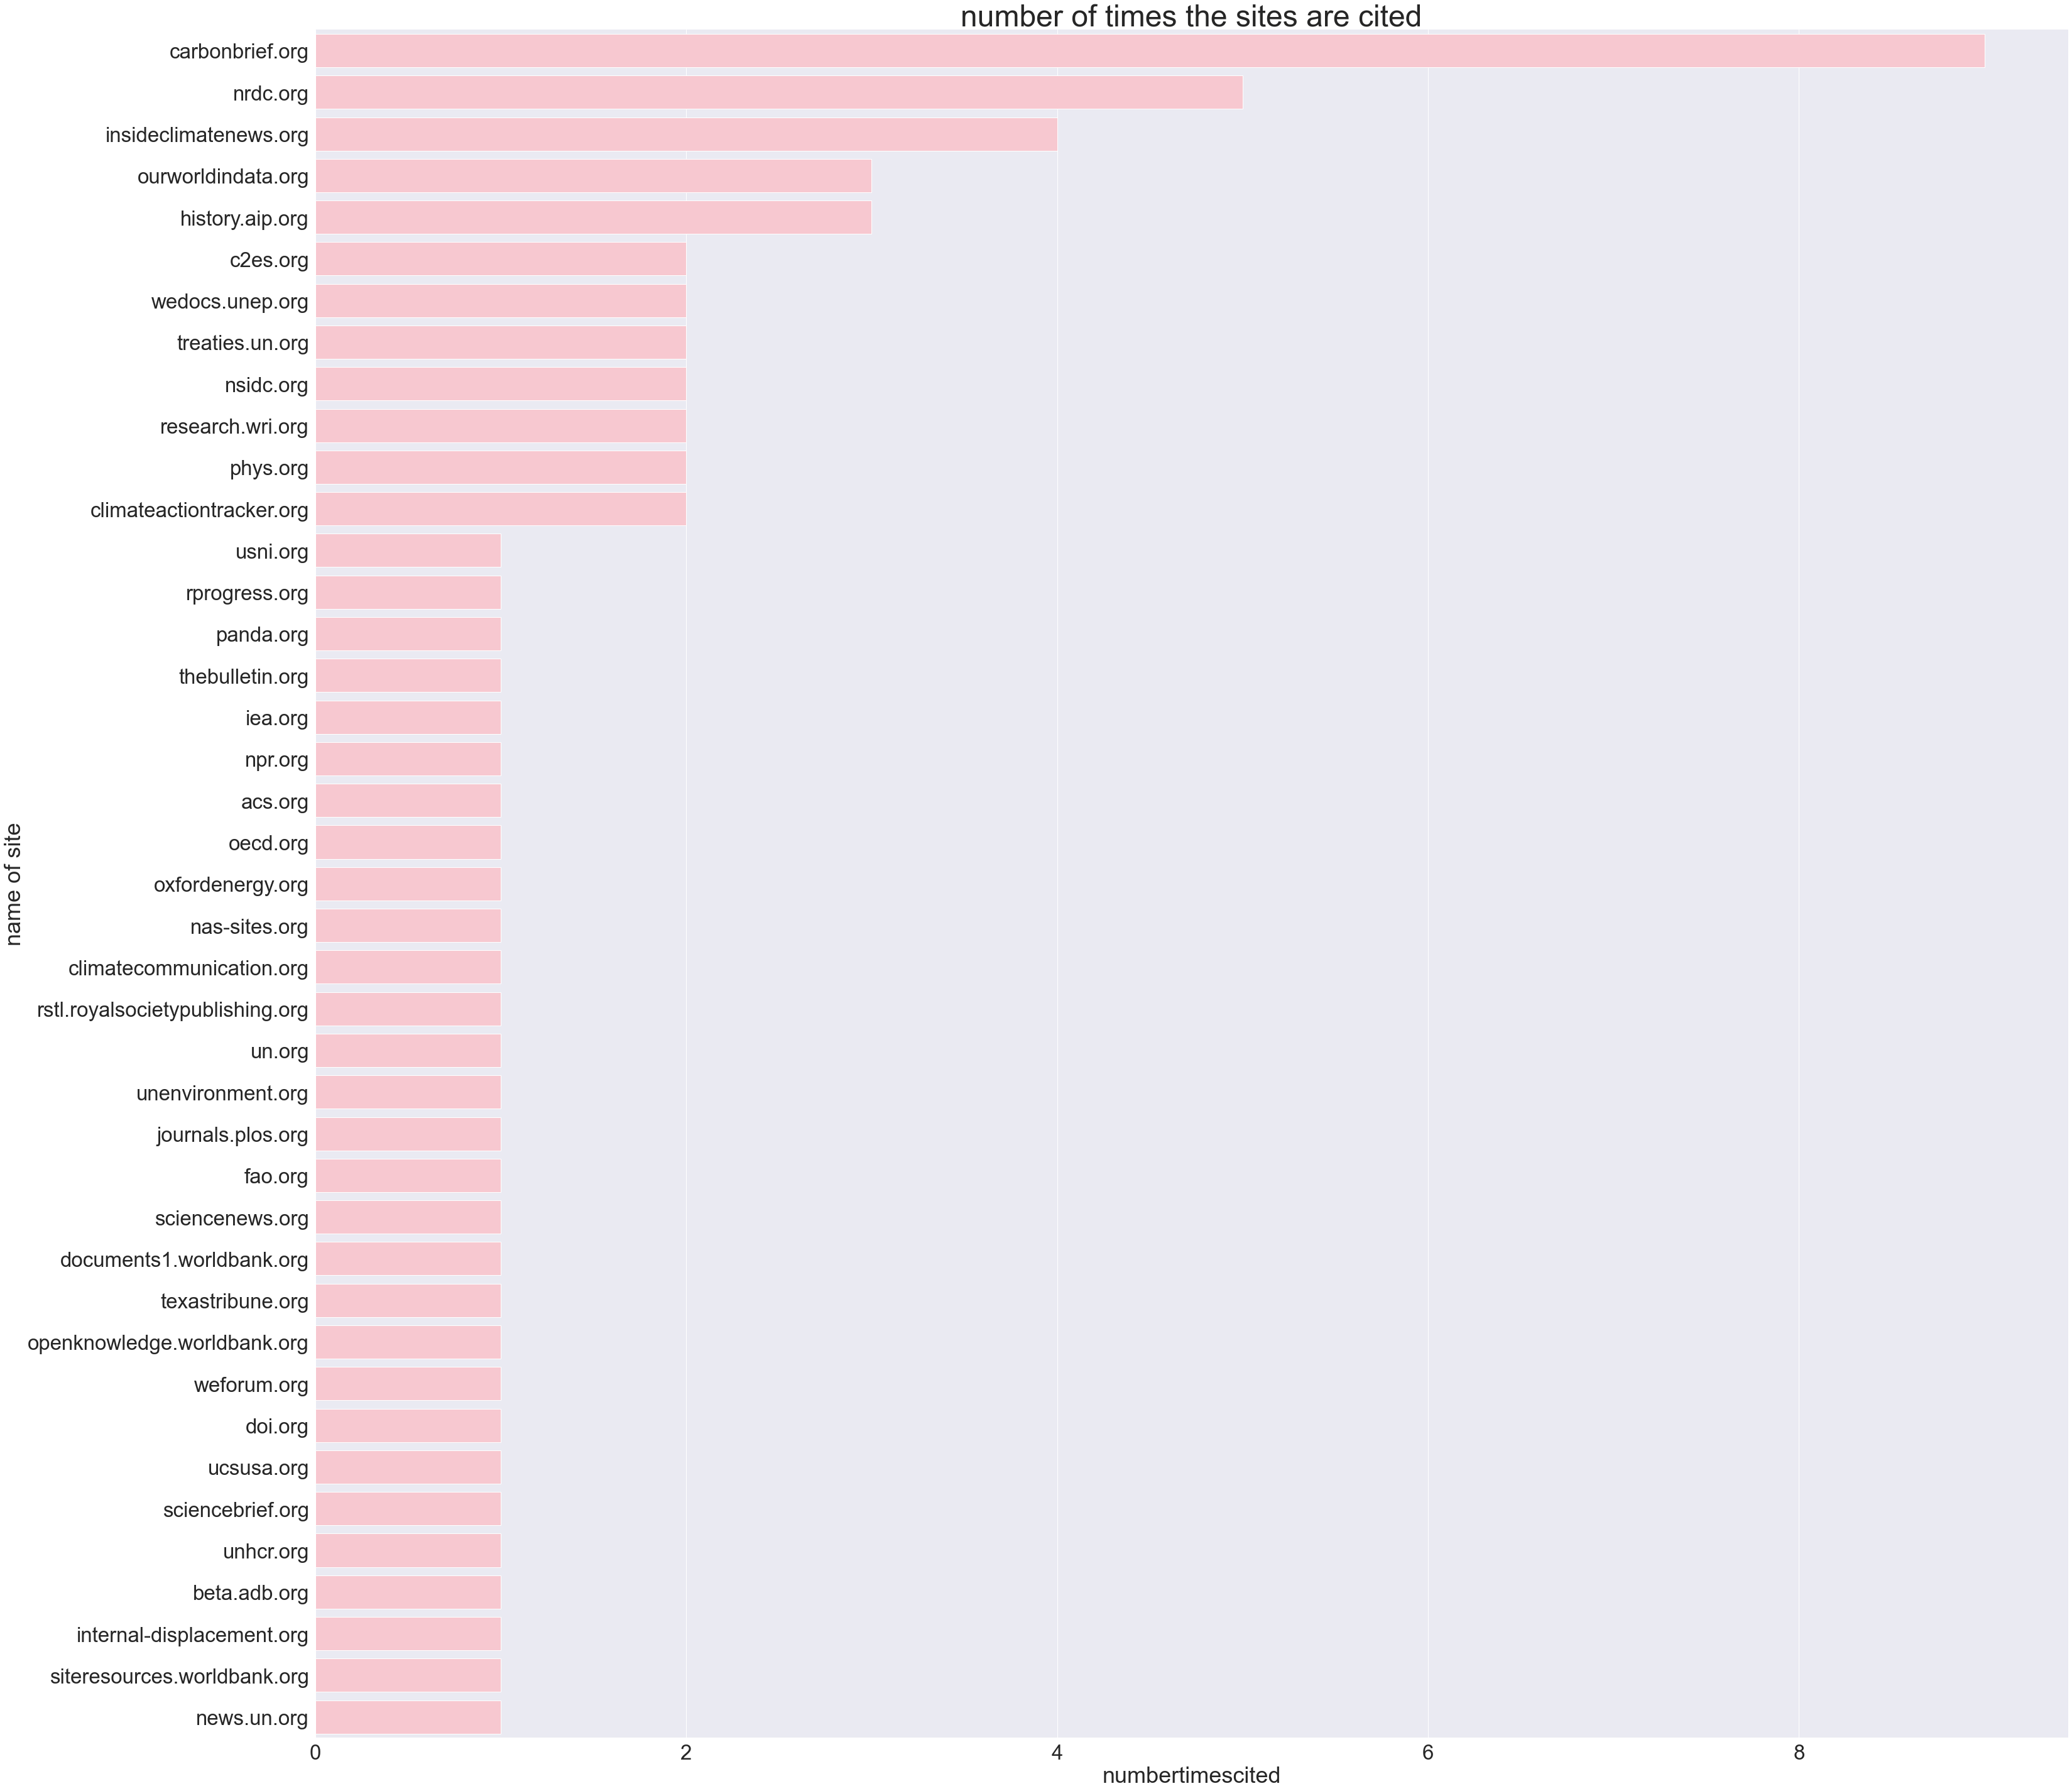

In [305]:
dforg,dico=sortcitation(df.loc[:,"citationorgtext"])
def plot_site_most_cited(d):
    sns.set(font_scale=3)
    sns.set_color_codes("pastel")
    sns.barplot(x="numbertimescited", y="name of site", data=d, color="pink",orient = 'h')
    sns.despine(left=True, bottom=True)
    sns.set(font_scale=4)
    plt.title("number of times the sites are cited")
    plt.gcf().set_size_inches(50,50)
plot_site_most_cited(dforg)

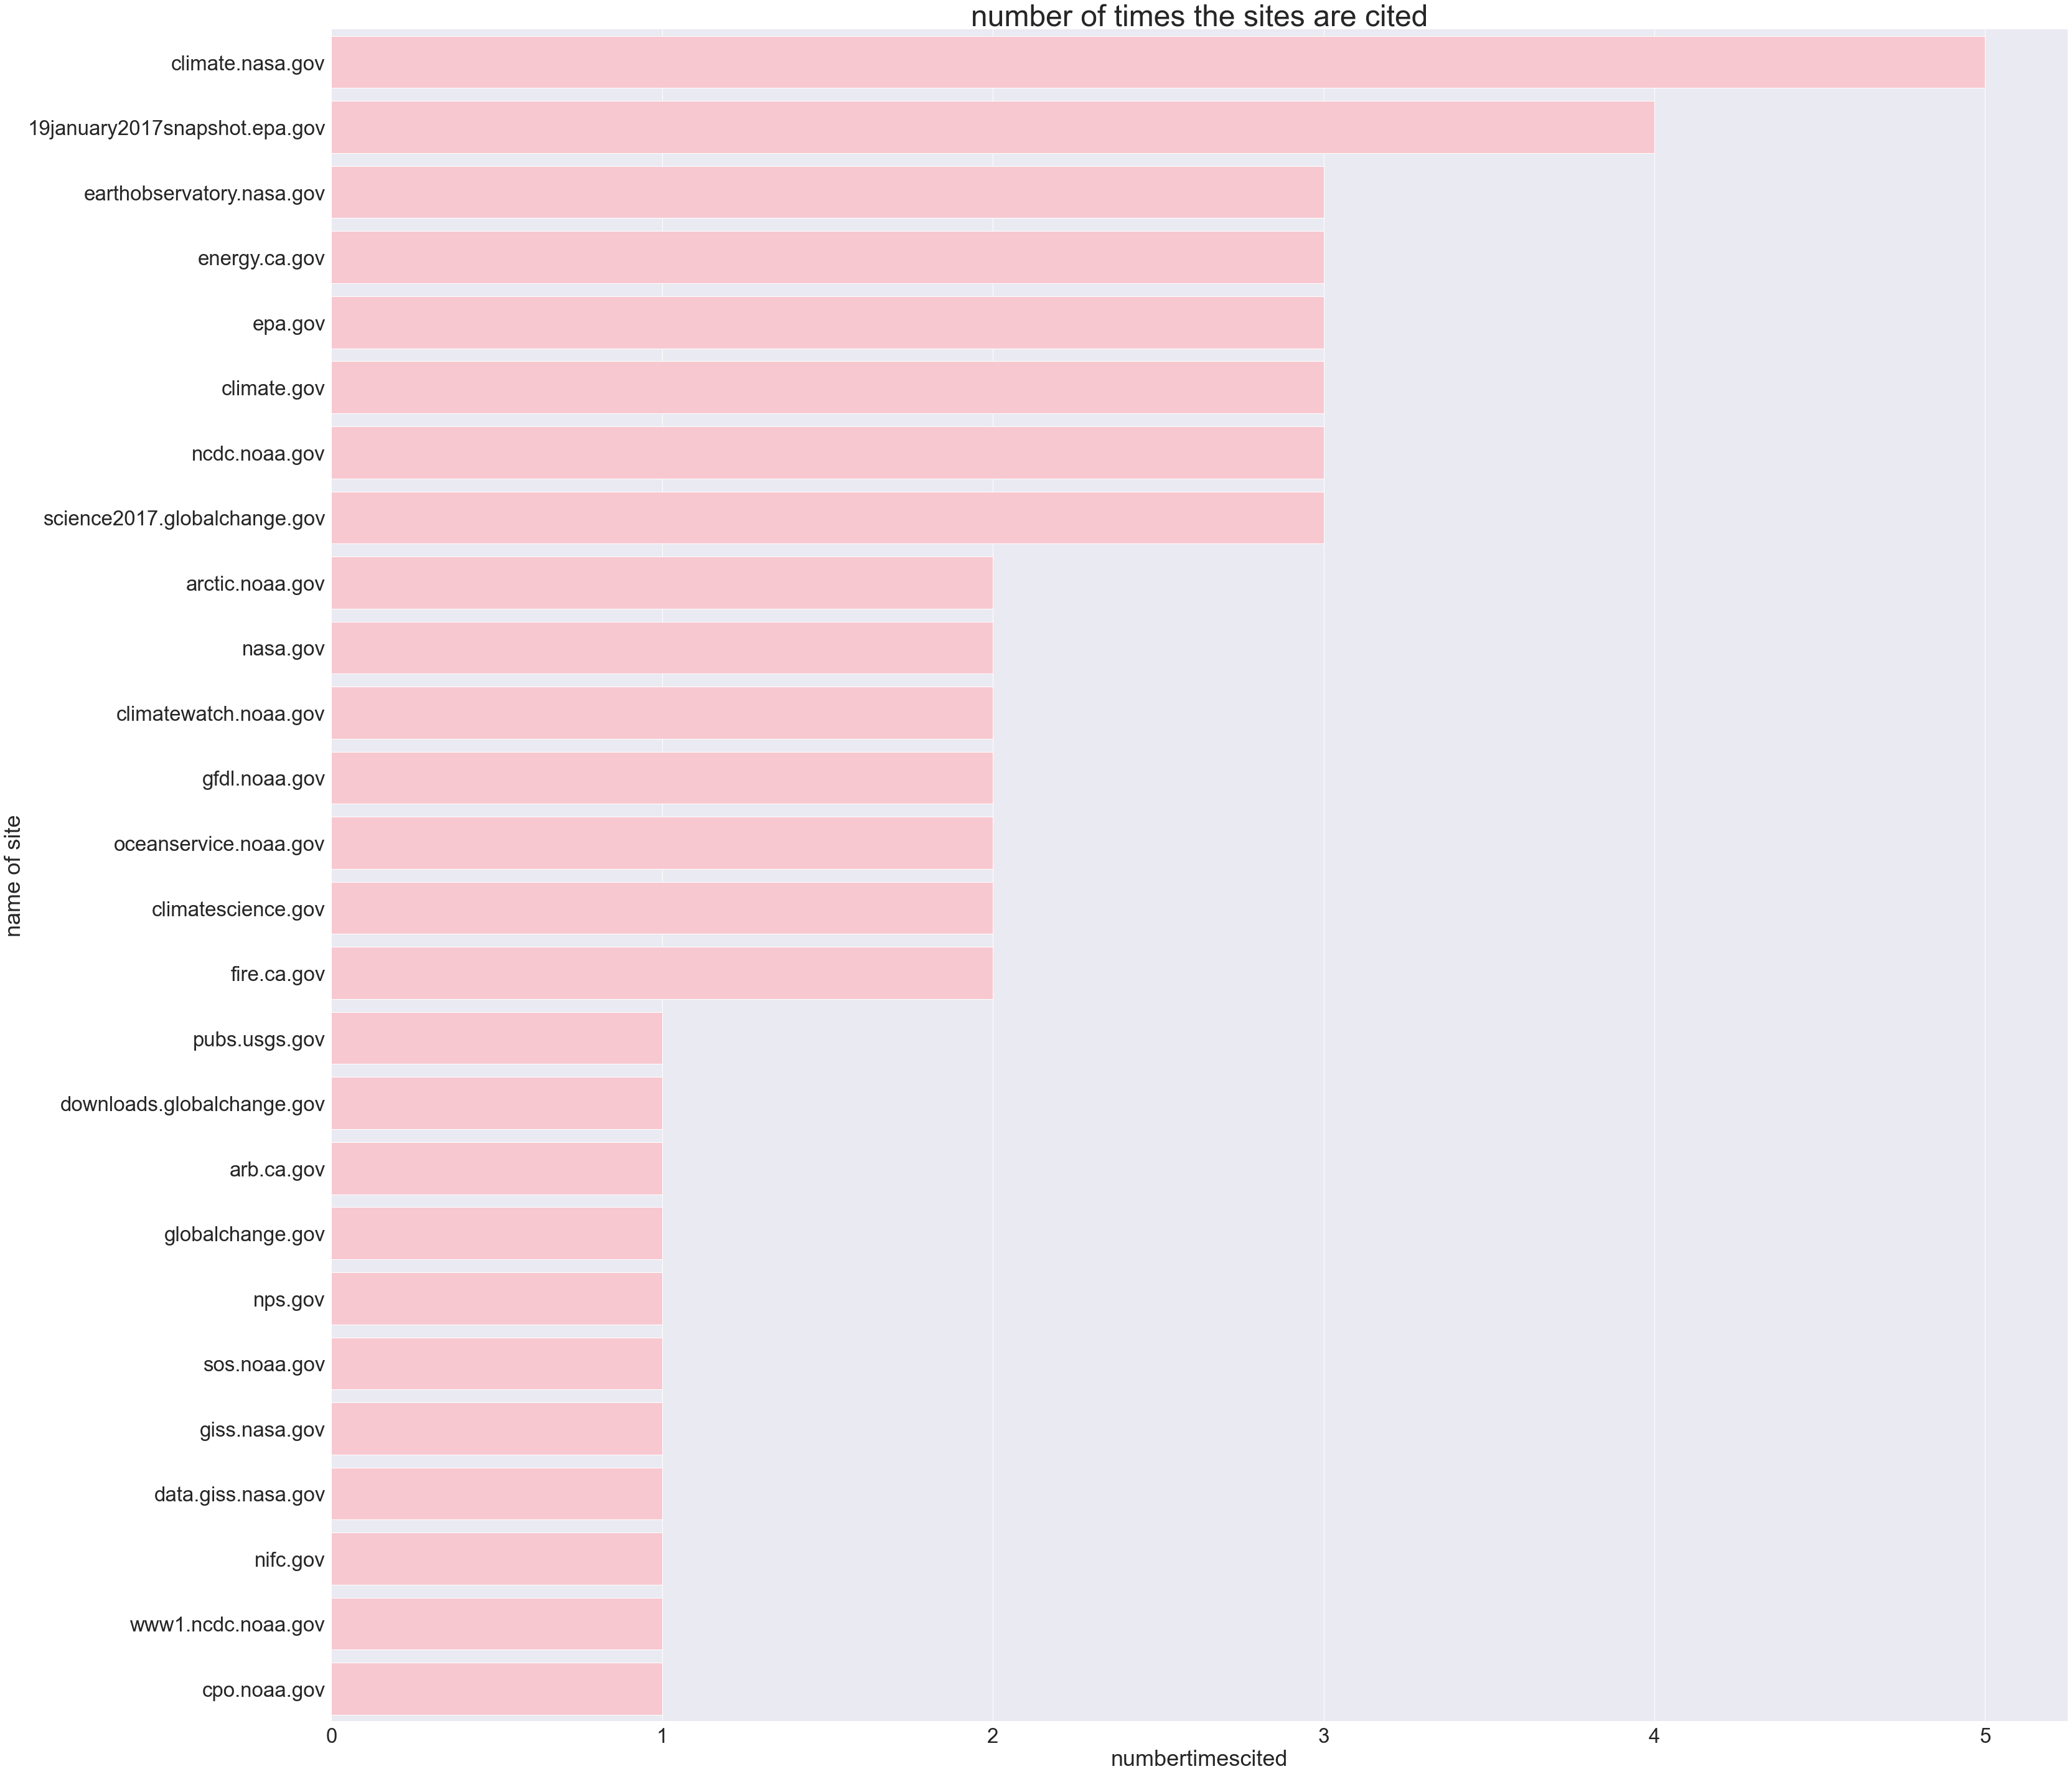

In [309]:
dfgov,j=sortcitation(df.loc[:,"citationgovtext"])
dfgov
plot_site_most_cited(dfgov)

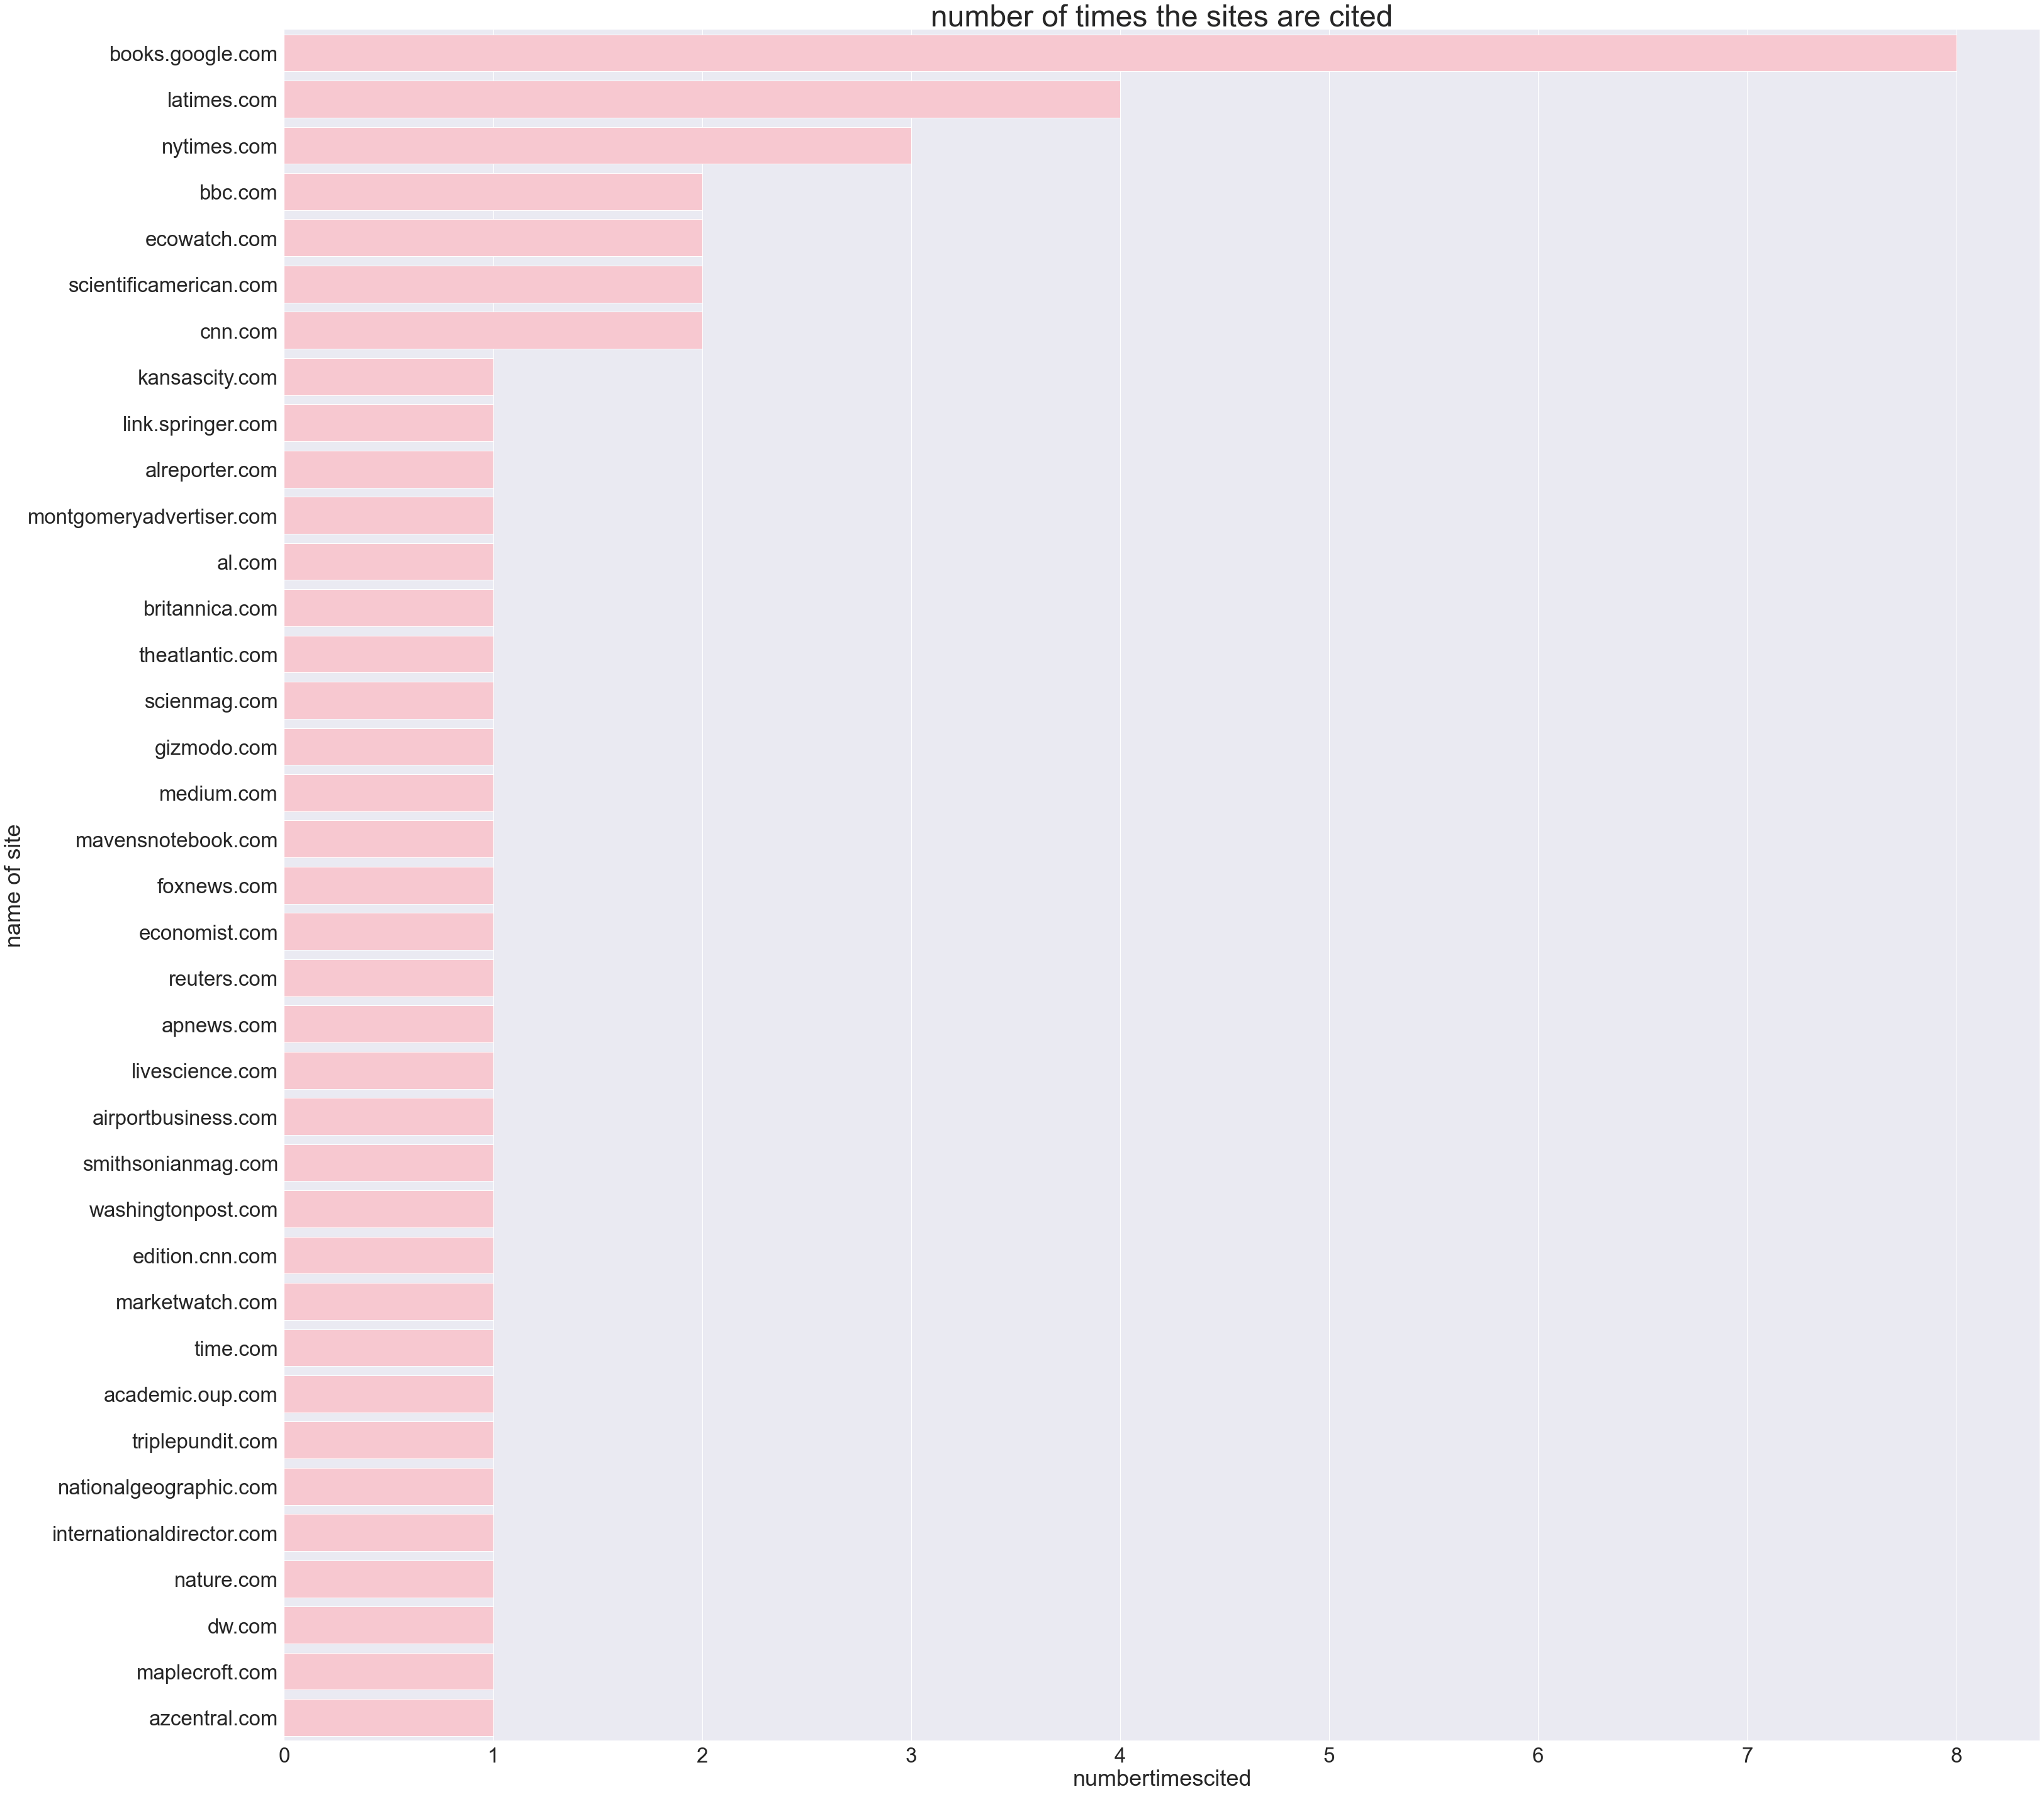

In [310]:
dcom,bl=sortcitation(df.loc[:,"citationcomtext"])
dcom
plot_site_most_cited(dcom)

## Evolution of the citation (To do only if the wikicode of old versions have been scrapped)

#### Plot of the evoltuion of the citations

In [ ]:
df.loc[0,["Name only"]]=2022
df.set_index("Name only",inplace=True)

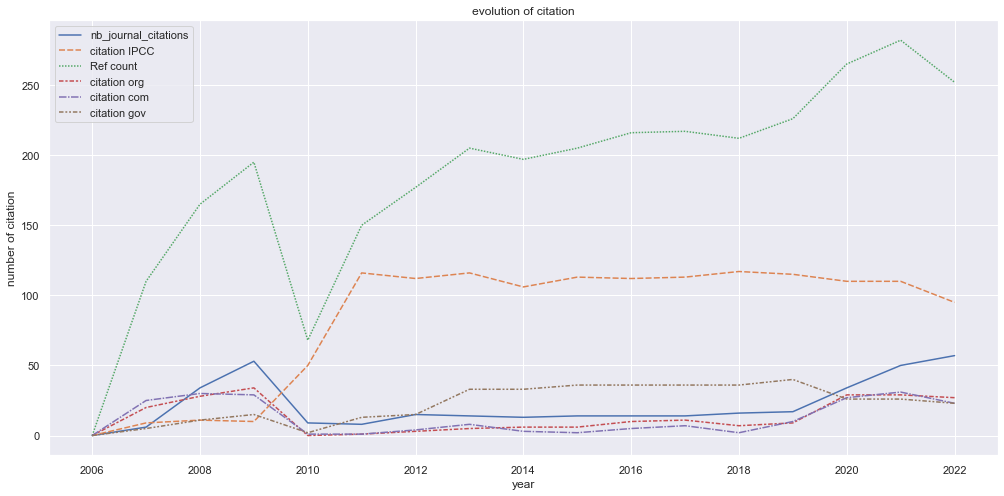

In [97]:
sns.lineplot(data=[df["nb_journal_citations"],df["citation IPCC"],df["Ref count"],df["citation org"],df["citation com"], df["citation gov"]]).set(title='evolution of citation',xlabel='year',ylabel='number of citation')
plt.savefig('evolution of citation.png')

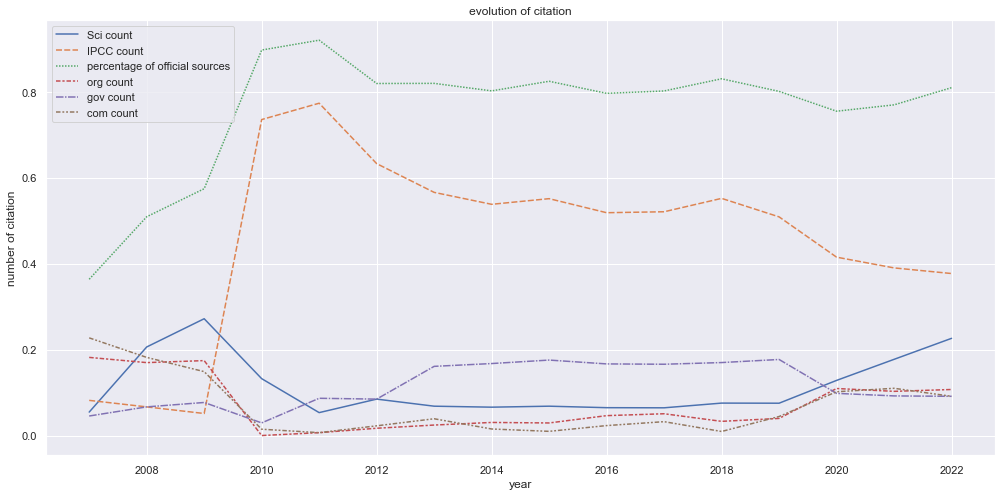

In [96]:
sns.set(rc = {'figure.figsize':(17,8)})
sns.lineplot(data=[df["Sci count"],df["IPCC count"],df['percentage of official sources'],df["org count"],df["gov count"],df["com count"]]).set(title='evolution of citation',xlabel='year',ylabel='number of citation')

plt.savefig('rate evolution of citation.png') 

#### dataframe containing the name of the evolution of the citation

In [ ]:
def crea_df_evolution_citation(df, end_cit :str):  
    '''
    creation of a dataframe containing the number of a name of a citation finishing by name_cit (exemple org) for each year
    
    param df : the df containing the information the citation for an article and it's past
    param end_cit : the type of citation we want to extract it can be either .org, .com or .gov citations
    
    return dorg: a dataframe with axis the year and the name of the citation 
    '''
    columntext="citation"+end_cit+"text"
    columnnumber= "citation "+end_cit
    dorg=pd.DataFrame()

    for i in range(2007,2022):
        if int(df.loc[i,columnnumber])!=0:
            dforg,dicorg=sortcitation(df.loc[i,columntext])
            for j in dicorg.keys():
                dorg.loc[i,[j]]= dicorg[j]

    dorg=dorg.fillna(0)            

    dorg.loc["total",:]=dorg.sum(0)
    dorg["somme"]=dorg.sum(1)
    #new_df = dorg.loc[:, dorg.loc["total"]>1]
    #dorg = new_df.drop('total')
    return dorg

crea_df_evolution_citation(df,"org")
crea_df_evolution_citation(df,"gov")
crea_df_evolution_citation(df,"com")
#plol_evol_cit(df.loc[i,["citationorg"]],df.loc[i,["citationorgtext"]])
dorg.to_csv('climatechangehistoricdorg.csv')

## Cleaning the column and exporting the data frame and scrap of page information

In [263]:
titlelist=df["Name only"].tolist() #make a list will all titles
#We need to recreate the wiki url, first step is to get rid of blanks
titleunderscore = [sub.replace(' ', '_') for sub in titlelist]

In [264]:
#We finally get from the original url to the pageinfo url
urlmodifié = ['https://en.wikipedia.org/w/index.php?title=' + i +'&action=info' for i in titleunderscore]
print(urlmodifié)

['https://en.wikipedia.org/w/index.php?title=Effects_of_climate_change&action=info', 'https://en.wikipedia.org/w/index.php?title=Climate_change&action=info', 'https://en.wikipedia.org/w/index.php?title=Bird_migration&action=info', 'https://en.wikipedia.org/w/index.php?title=Climate_change_in_Alabama&action=info', 'https://en.wikipedia.org/w/index.php?title=Climate_change_in_California&action=info', 'https://en.wikipedia.org/w/index.php?title=Climate_change_in_Arizona&action=info']


In [270]:
#Cell to scrap infos from "page info" section (2 to scrap the third table of the page)
doblist=[]
creatorlist=[]
totaledits=[]
recentedits=[]
pageid=[]
pagelenght=[]
editprotection=[]
recentpageviews=[]

for i in tqdm(urlmodifié) :
    source = requests.get(i)
    soup = BeautifulSoup(source.text, 'lxml')
    #soup = BeautifulSoup(source, "html.parser", from_encoding="utf-8")
    alltables=soup.findAll('table', {"class": "wikitable mw-page-info"})
    tableau_html_liste=pd.read_html(str(alltables)) #We get it as a list   
    df_pageinfo2=pd.DataFrame(tableau_html_liste[2]) #And make it a df 
    #The number between brackets corresponds to the number of the table according to its order on the html page
    creatorlist += [df_pageinfo2.iat[0, 1]]
    doblist += [df_pageinfo2.iat[1, 1]]
    totaledits += [df_pageinfo2.iat[4, 1]]
    recentedits += [df_pageinfo2.iat[5, 1]]
    
    
    #Scrap of the first table of the page (0)
    df_pageinfo0=pd.DataFrame(tableau_html_liste[0])
    pagelenght += [df_pageinfo0.iat[2, 1]]
    pageid += [df_pageinfo0.iat[3, 1]]
    #recentpageviews += [df_pageinfo0.loc['Page views in the past 30 days']]
            
    
    #Scrap of the second table of the page (1)
    df_pageinfo1=pd.DataFrame(tableau_html_liste[1])
    editprotection += [df_pageinfo1.iat[1, 1]]
  

    

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:05<00:00,  1.11it/s]


In [271]:
#Cell to add the new lists as new columns of the df
df["Page id"]=pageid
df["Edit protection"]=editprotection
df["Page lenght (Bytes)"]=pagelenght
df["DOB"]=doblist
df["Creator"]=creatorlist
df["Total edits"]=totaledits
df["Recent edits"]=recentedits
df.head()

,Name only,page url,text,citations,Ref count,nb_journal_citations,journalcitation,citation org,citationorgtext,citation gov,...,Page id,Edit protection,Page lenght (Bytes),DOB,Creator,Total edits,Recent edits,Formated DOB,Year_month,Year
0,Effects of climate change,https://en.wikipedia.org/wiki/Effects_of_clima...,{{short description|Effects created by climate...,"{'Ref count': 252, 'nb_journal_citations': 57,...",252,57,"[10.1073/pnas.1003292107, 10.1016/j.egycc.2020...",28,"[news.un.org, openknowledge.worldbank.org, www...",24,...,2119174,Require autoconfirmed or confirmed access (no ...,186247,"15:09, 26 June 2005",Rd232 (talk | contribs),5537,19,2005-06-26,2005-06,2005
1,Climate change,https://en.wikipedia.org/wiki/Climate_change,{{Short description|Current rise in Earth's av...,"{'Ref count': 603, 'nb_journal_citations': 114...",603,114,"[10.1596/978-1-4648-0673-5, 10.1126/science.12...",28,"[www.fao.org, ourworldindata.org, www.unenviro...",16,...,5042951,Require administrator access (no expiry set),271827,"17:25, 30 October 2001",Zundark (talk | contribs),25732,39,2001-10-30,2001-10,2001
2,Bird migration,https://en.wikipedia.org/wiki/Bird_migration,['Large scale [[global warming|climatic change...,"{'Ref count': 5, 'nb_journal_citations': 4, 'c...",5,4,"[10.1038/nature04539, 10.1111/conl.12386, 10.1...",1,[www.panda.org],0,...,201943,Allow all users (no expiry set),91540,"07:15, 27 March 2003",195.93.32.9 (talk),1708,6,2003-03-27,2003-03,2003
3,Climate change in Alabama,https://en.wikipedia.org/wiki/Climate_change_i...,{{Short description|Climate change in the US s...,"{'Ref count': 8, 'nb_journal_citations': 0, 'c...",8,0,[],0,[],1,...,54374960,Allow all users (no expiry set),12299,"15:09, 23 June 2017",BD2412 (talk | contribs),72,0,2017-06-23,2017-06,2017
4,Climate change in California,https://en.wikipedia.org/wiki/Climate_change_i...,{{Short description|Climate change in the US s...,"{'Ref count': 52, 'nb_journal_citations': 9, '...",52,9,"[10.1073/pnas.0404500101, 10.1073/pnas.1617464...",10,"[phys.org, rprogress.org, www.nrdc.org, inside...",9,...,18159949,Allow all users (no expiry set),35848,"10:29, 27 June 2008",Mac (talk | contribs),446,5,2008-06-27,2008-06,2008


In [272]:
#Cleaning the table

#Getting rid of the time
df["DOB"]= df["DOB"].str.slice(7,100,1) 
#peutêtre qu'on pourrait mettre comme end point la len de la string

#Format the date
df["Formated DOB"]=pd.to_datetime(df["DOB"], format='%d %B %Y')
df["Year_month"]= pd.to_datetime(df['DOB']).dt.to_period('M')

#Getting the year
df['Year'] = pd.DatetimeIndex(df['DOB']).year

#Cleaning the creator 
df["Creator"]= df["Creator"].str.replace(r"\(.*\)",'', regex=True)

#### Plot the ratio of page created by a certain editor in our corpus

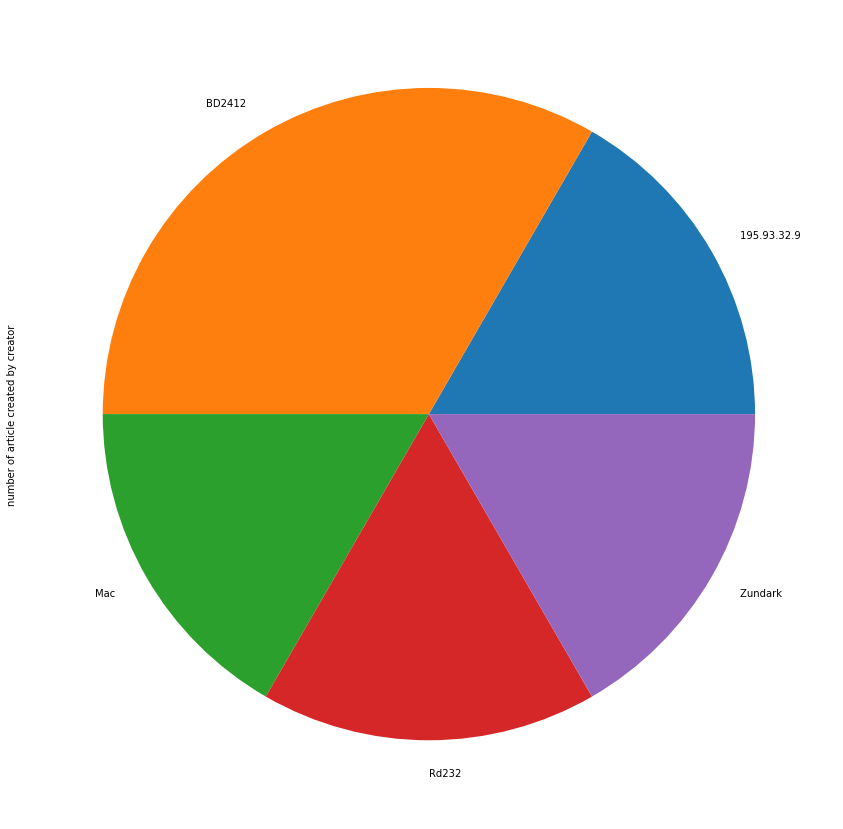

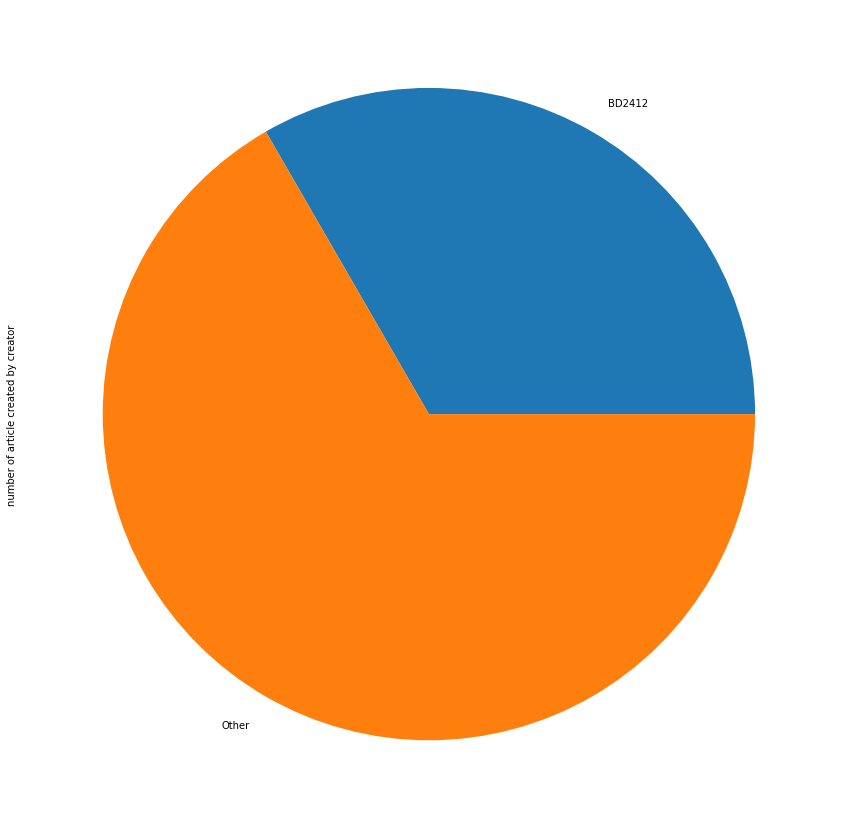

In [273]:
#creation of a new dataframe
dfbis=df

dfbis["number of article created by creator"]=1
dfbis.set_index("Creator",inplace=True)
dfbis=dfbis.groupby("Creator")["number of article created by creator"].sum()

fig = plt.figure(0,figsize=(20,15))
dfbis.plot.pie(subplots=True)
fig.savefig('article_created_by_creator.jpg', bbox_inches='tight', dpi=150)

dftris=dfbis[dfbis==1].sum()
dfbis.loc["Other"]=dftris


fig2 = plt.figure(1,figsize=(20,15))
dfbis[dfbis>1].plot.pie(subplots=True)
fig2.savefig('article_created_by_important_creator.jpg', bbox_inches='tight', dpi=150)

plt.show()

#### plot of the timeline

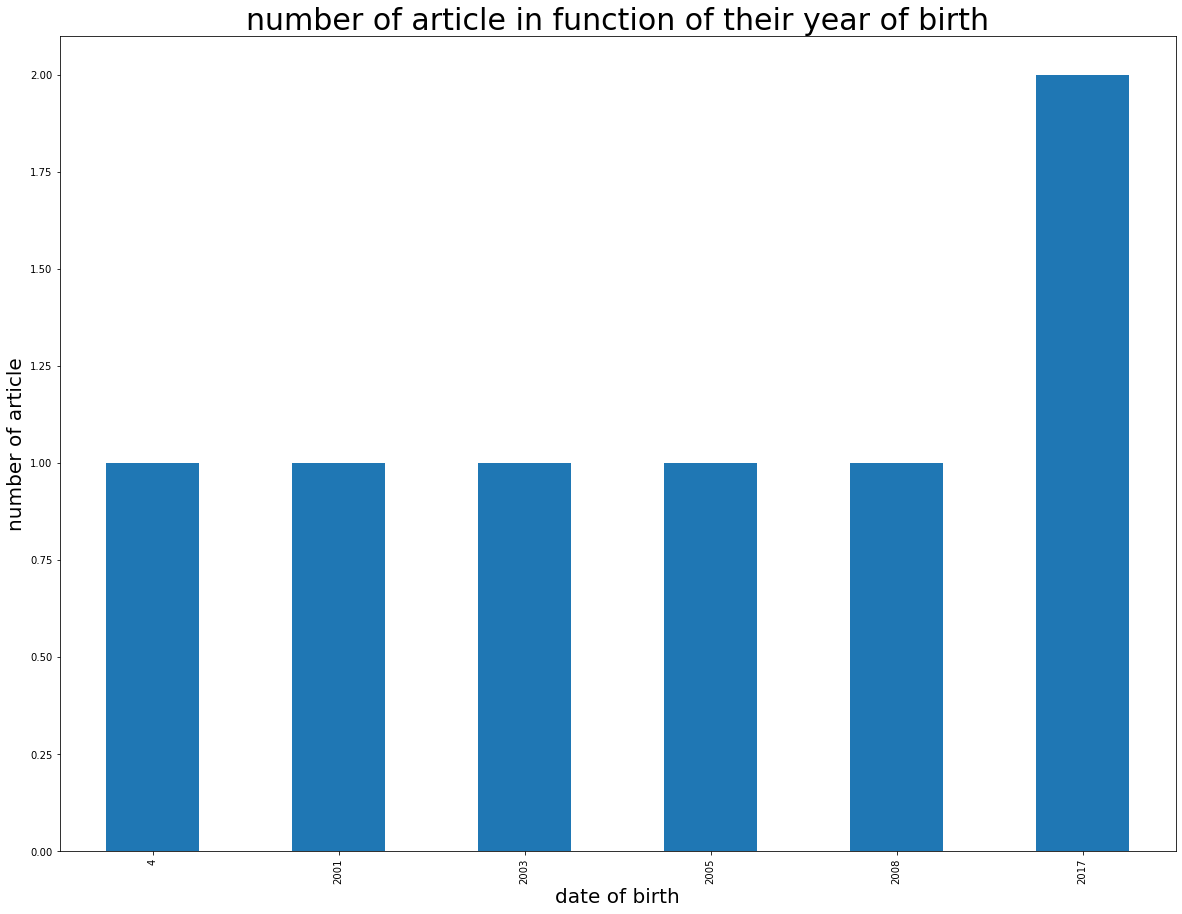

In [249]:
fig = plt.figure(0,figsize=(20,15))
plothist=df["Year"].value_counts().sort_index().plot(kind="bar")
fig.savefig('timeline.jpg', bbox_inches='tight', dpi=150)
plt.xlabel('date of birth',fontsize = 20) 
plt.ylabel('number of article',fontsize = 20) 
plt.title("number of article in function of their year of birth",fontsize = 30)
plt.show()

#### Clean and export the dataframes to csv

In [258]:
del df['citationorgtext']
del df['citationgovtext']
del df['text']
del df["citations"]
del df["citationcomtext"]

In [40]:
df.to_csv('climatechange.csv')
dforg.to_csv('climatechangeorg.csv')
dfgov.to_csv('climatechangegov.csv')
dcom.to_csv('climatechangecom.csv')

#### Next is xtools part, ignore it 

In [274]:

prose_dic=[]
unique_references_xtools=[]
key = "unique_references"
for i in tqdm(urlxtools_prose) :
    prose_str=requests.get(i).text
    prose_dic = json.loads(prose_str)
    unique_references_xtools.append(prose_dic[key])


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.76it/s]


In [275]:
df['unique_references_xtools']=unique_references_xtools

In [276]:
df.head()
df.to_csv('Corpus_CC_V3.csv')

In [277]:
for i in urlxtools_edits:
    print(requests.get(i).text)


<!DOCTYPE html>
<html lang="en">
<head>
    <title>
        Error - XTools
    </title>

        <script type="text/javascript">
        xtBaseUrl = "/";

                i18nLang = "en";
        i18nPaths = {};
                    i18nPaths["en"] = "/i18n/en.json";
                    i18nPaths["en"] = "/i18n/en.json";
        
        i18nRTL = false;
    </script>

            <script type="text/javascript" src="https://tools-static.wmflabs.org/cdnjs/ajax/libs/jquery/3.3.1/jquery.min.js"></script>
        <script type="text/javascript" src="/assets/app.b091821e.js"></script>
        <script type="text/javascript" src="https://tools-static.wmflabs.org/cdnjs/ajax/libs/twitter-bootstrap/3.3.7/js/bootstrap.min.js"></script>
        <script src="https://tools-static.wmflabs.org/cdnjs/ajax/libs/select2/4.0.5/js/select2.full.min.js"></script>
                <link rel="stylesheet" type="text/css" media="screen" href="https://tools-static.wmflabs.org/cdnjs/ajax/libs/twitter-bootstrap/3.3.7

Trying to extract for weird formatted type but only one in our corpus => not necessary to do a program

In [278]:
for i in df["Ref count"]:
    if i==0:
        
            page = wikipedia.page(df.loc[i, "Name only"])
            print(df.loc[i, "Name only"])
            
            soup = BeautifulSoup(page.html(), 'html.parser')
            citations =soup.find_all('cite', {'class':"citation cs2"})
            for c in citations:
                test= get_ids_from_ref(str(c))

In [24]:
df

,Name only,page url,text,citations,Ref count,nb_journal_citations,journalcitation,citation org,citationorgtext,citation gov,...,citationcomtext,citationipbes,citationguardian,citationautre,org count,gov count,com count,Sci count,IPCC count,percentage of official sources
0,Effects of climate change,https://en.wikipedia.org/wiki/Effects_of_clima...,{{short description|Effects created by climate...,"{'Ref count': 252, 'nb_journal_citations': 57,...",252,57,"[10.1007/s10584-014-1084-5, 10.1016/j.geoforum...",27,"[[www.ucsusa.org], [openknowledge.worldbank.or...",23,...,"[[academic.oup.com], [www.nationalgeographic.c...",2,10,[{{cite web |title=motion for a resolution on ...,0.107143,0.091270,0.091270,0.226190,0.376984,0.809524
1,History of climate change science,https://en.wikipedia.org/wiki/History_of_clima...,{{short description|Aspect of the history of s...,"{'Ref count': 91, 'nb_journal_citations': 28, ...",91,28,"[10.1007/bf00139058, 10.1175/1520-0469(1967)02...",20,"[[history.aip.org], [www.nobelprize.org], [www...",4,...,"[[books.google.com], [books.google.com], [www....",0,2,"[john p. holdren: ""global thermal pollution"", ...",0.219780,0.043956,0.109890,0.307692,0.010989,0.582418
2,Climate change,https://en.wikipedia.org/wiki/Climate_change,{{Short description|Current rise in Earth's av...,"{'Ref count': 603, 'nb_journal_citations': 114...",603,114,"[10.1038/nclimate2979, 10.1002/2017rg000559, 1...",28,"[[www.carbonbrief.org], [www.un.org], [ourworl...",16,...,"[[books.google.com], [books.google.com], [book...",0,15,[{{cite web\n |title=the climate regime from t...,0.046434,0.026534,0.013267,0.189055,0.255390,0.517413
3,Effects of climate change on plant biodiversity,https://en.wikipedia.org/wiki/Effects_of_clima...,[[File:Alpine flora logan pass.jpg|380px|thumb...,"{'Ref count': 60, 'nb_journal_citations': 41, ...",60,41,"[10.1007/s10113-015-0870-6, 10.1016/j.tplants....",3,"[[archive.org], [www.millenniumassessment.org]...",3,...,[[justenergy.com]],0,0,"[{{cite conference |author=mackey, b. |title=c...",0.050000,0.050000,0.016667,0.683333,0.000000,0.783333
4,Climate change feedback,https://en.wikipedia.org/wiki/Climate_change_f...,{{short description|Feedback related to climat...,"{'Ref count': 103, 'nb_journal_citations': 45,...",103,45,"[10.1038/s41558-018-0344-1, 10.1029/gb002i003p...",10,"[[www.iucn.org], [climateprogress.org], [www.n...",11,...,"[[www.upi.com], [books.google.com], [www.washi...",0,6,[{{cite web |url=http://geotest.tamu.edu/userf...,0.097087,0.106796,0.077670,0.436893,0.077670,0.718447
5,Effects of climate change on terrestrial animals,https://en.wikipedia.org/wiki/Effects_of_clima...,{{Multiple issues|\n{{cleanup reorganize|date=...,"{'Ref count': 67, 'nb_journal_citations': 47, ...",67,47,[10.1175/1520-0477(2000)081<0413:aittie>2.3.co...,4,"[[www.pbs.org], [www.iucn.org], [cwf-fcf.org],...",1,...,"[[softbacktravel.com], [theconversation.com], ...",0,0,"[mitchell, d., fuller, a., hetem, r. s., & mal...",0.059701,0.014925,0.119403,0.701493,0.014925,0.791045
6,Effects of climate change on oceans,https://en.wikipedia.org/wiki/Effects_of_clima...,{{Short description|Effects of climate change ...,"{'Ref count': 121, 'nb_journal_citations': 64,...",121,64,"[10.1175/jcli-d-20-0366.1, 10.1017/s0030605307...",14,"[[www.sciencemag.org], [worldcat.org], [www.re...",3,...,"[[www.ecowatch.com], [www.sciencedaily.com], [...",0,1,"[usgs world energy assessment team, 2000. us g...",0.115702,0.024793,0.074380,0.528926,0.074380,0.743802
7,Attribution of recent climate change,https://en.wikipedia.org/wiki/Attribution_of_r...,{{pp-semi-indef}}\n{{Use dmy dates|date=Decemb...,"{'Ref count': 112, 'nb_journal_citations': 21,...",112,21,"[10.1038/nature05718, 10.1093/ijpor/edr033, 10...",12,"[[www.virtualcentre.org], [americasclimatechoi...",23,...,"[[www.ecowatch.com], [www.ecowatch.com], [spac...",0,0,"[{{harvnb|karl|others|2009}}, p. 20., {{harvnb...",0.107143,0.205357,0.080357,0.187500,0.232143,0.732143
8,Human impact